# Lab 9

Author: Mateusz Stączek

In [96]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(63456521)

# Task 1

## a)

Generate n = 500 observations from the following mixture distribution:

$$0.3 \cdot \mathcal{N}(1,1) + 0.7 \cdot \mathcal{N}(5,2)$$

<!-- True parameter values: μ0 = 1, μ1 = 5, σ20 = 1, σ21 = 2, π0 = 0.3, π1 = 0.7. We will denote the set of al
the parameters as θ - θ = (μ0,μ1,σ20,σ21,π0,π1) (there is a slight overparametrization as π1 = 1 −π0, but
it doesn’t matter). Draw a histogram of a sample and the true distribution -->

True parameter values: $\mu_0 = 1$, $\mu_1 = 5$, $\sigma_0^2 = 1$, $\sigma_1^2 = 2$, $\pi_0 = 0.3$, $\pi_1 = 0.7$. We will denote the set of all the parameters as $\theta - \theta = (\mu_0, \mu_1, \sigma_0^2, \sigma_1^2, \pi_0, \pi_1)$ (there is a slight overparametrization as $\pi_1 = 1 - \pi_0$, but it doesn't matter). Draw a histogram of a sample and the true distribution.

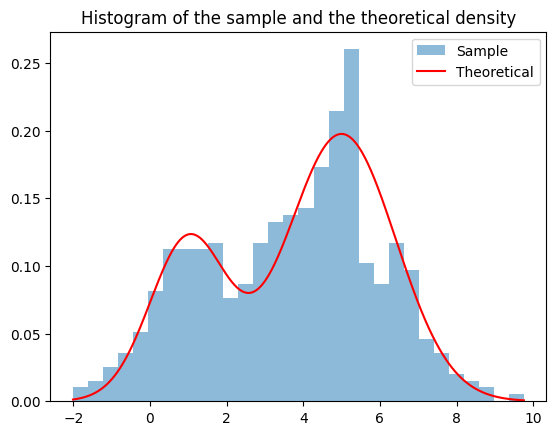

In [97]:
n = 500

# Generate random data and theoretical density
X_sample = np.array([np.random.normal(1, 1) if np.random.rand() < 0.3 else np.random.normal(5, np.sqrt(2)) for _ in range(n)])
X_theoretical = np.linspace(min(X_sample), max(X_sample), 1000)
Y_theoretical = np.array([0.3*np.exp(-0.5*(x-1)**2/1)/np.sqrt(2*np.pi*1)+0.7*np.exp(-0.5*(x-5)**2/2)/np.sqrt(2*np.pi*2) for x in X_theoretical])

plt.hist(X_sample, bins=30, density=True, alpha=0.5, label='Sample')
plt.plot(X_theoretical, Y_theoretical, color='red', label='Theoretical')
plt.title('Histogram of the sample and the theoretical density')
plt.legend()
plt.show()

## b)

Assume that the mixing variable $G$ is known (meaning that $G = 0$ if the observation comes from the first normal distribution and $G = 1$ if it comes from the second). Write the formula of the loglikelihood: $\sum_{i=1}^n \log(p(x_i, G_i = g_i | \theta))$, $g = 0,1$.

In [98]:
loglikelihood = lambda x,g,mu1,mu2,sigma1,sigma2,pi1,pi2: np.sum(
    g * (np.log(pi2) - np.log(2*np.pi*sigma2)/2 - 0.5*(x-mu2)**2/sigma2) +
    (1-g) * (np.log(pi1) - np.log(2*np.pi*sigma1)/2 - 0.5*(x-mu1)**2/sigma1)
)

Trying with 2 peaks of theoretical distribution.

In [99]:
np.e**loglikelihood(np.array([1]), np.array([0]), 1, 5, 1, 2, 0.3, 0.7)

0.11968268412042979

In [100]:
np.e**loglikelihood(np.array([5]), np.array([1]), 1, 5, 1, 2, 0.3, 0.7)

0.19746635424171471

## c)

<!-- (E-step computations) Compute the expected values of not observed variables. (A hint: we don’t observe
G, so we need to compute γi := EGi|Xi,θ). -->

(E-step computations) Compute the expected values of not observed variables. (A hint: we don't observe $G$, so we need to compute $\gamma_i := E(G_i | X_i, \theta)$).


In [101]:
gamma_1 = lambda x,mu1,mu2,sigma1,sigma2,pi1,pi2: (pi2*np.exp(-0.5*(x-mu2)**2/sigma2)/(np.sqrt(2*np.pi*sigma2)))/(pi1*np.exp(-0.5*(x-mu1)**2/sigma1)/(np.sqrt(2*np.pi*sigma1))+pi2*np.exp(-0.5*(x-mu2)**2/sigma2)/(np.sqrt(2*np.pi*sigma2)))

Check in peaks.

In [102]:
1-gamma_1(np.array([1]), 1, 5, 1, 2, 0.3, 0.7) # for g=0, I substract E(g=1|X,theta) from 1

array([0.97066715])

In [103]:
gamma_1(np.array([5]), 1, 5, 1, 2, 0.3, 0.7) # directly E(g=1|X,theta)

array([0.99979672])

## d)

(M-step computations) Now we want to find the update equations for all the parameters $\theta$:
- $\mu_0$ (and analogously $\mu_1$),
- $\sigma_0^2$ (and analogously $\sigma_1^2$),
- $\pi_0$ (and analogously $\pi_1$).

In [104]:
get_updated_mu1    = lambda x,g: np.sum((1-g)*x)/np.sum(1-g)
get_updated_mu2    = lambda x,g: np.sum(g*x)/np.sum(g)
get_updated_sigma1 = lambda x,g,mu1: np.sum((1-g)*(x-mu1)**2)/np.sum(1-g)
get_updated_sigma2 = lambda x,g,mu2: np.sum(g*(x-mu2)**2)/np.sum(g)
get_updated_pi1    = lambda g: np.sum(1-g)/len(g)
get_updated_pi2    = lambda g: np.sum(g)/len(g)

## e)

<!-- Implement EM algorithm:
•Draw initial values for parameters: ˆμ0, ˆμ0, ˆσ0, ˆσ1, fix ˆπ0 = ˆπ1 = 1/2.
•For each observation, calculate weights γi (E-step). In the formula obtained in step c), plug-in all
current values of the parameters θ.
•Calculate new values of the parameters ˆμ0, ˆμ0, ˆσ0, ˆσ1, ˆπ0, ˆπ1 using the formula from d), using
previously calculated weights γi instead of Gi.
•Repeat the last two steps (2-3) until the algorithm converges (you can set any stopping criterion
based on loglikelihood, the fact that parameter estimators in successive steps will not differ much
from each other, or simply set a maximum number of steps). -->

Implement EM algorithm:
- Draw initial values for parameters: $\hat{\mu}_0$, $\hat{\mu}_1$, $\hat{\sigma}_0$, $\hat{\sigma}_1$, fix $\hat{\pi}_0 = \hat{\pi}_1 = 1/2$.
- For each observation, calculate weights $\gamma_i$ (E-step). In the formula obtained in step c), plug-in all current values of the parameters $\theta$.
- Calculate new values of the parameters $\hat{\mu}_0$, $\hat{\mu}_1$, $\hat{\sigma}_0$, $\hat{\sigma}_1$, $\hat{\pi}_0$, $\hat{\pi}_1$ using the formula from d), using previously calculated weights $\gamma_i$ instead of $G_i$.
- Repeat the last two steps (2-3) until the algorithm converges (you can set any stopping criterion based on loglikelihood, the fact that parameter estimators in successive steps will not differ much from each other, or simply set a maximum number of steps).


In [105]:
def EM(X, tol=1e-6):
    mu1 = np.random.normal()
    mu2 = np.random.normal()
    sigma1 = np.random.rand()
    sigma2 = np.random.rand()
    pi1 = 0.5
    pi2 = 0.5

    loglikelihoods = []
    while True:
        g = gamma_1(X, mu1, mu2, sigma1, sigma2, pi1, pi2)
        updated_mu1    = get_updated_mu1(X, g)
        updated_mu2    = get_updated_mu2(X, g)
        updated_sigma1 = get_updated_sigma1(X, g, updated_mu1)
        updated_sigma2 = get_updated_sigma2(X, g, updated_mu2)
        updated_pi1    = get_updated_pi1(g)
        updated_pi2    = get_updated_pi2(g)
        loglikelihoods.append(loglikelihood(X, g, updated_mu1, updated_mu2, updated_sigma1, updated_sigma2, updated_pi1, updated_pi2))
        if len(loglikelihoods) > 1 and abs(loglikelihoods[-1] - loglikelihoods[-2]) < tol:
            print('Converged after', len(loglikelihoods), 'iterations.')
            break
        mu1, mu2, sigma1, sigma2, pi1, pi2 = updated_mu1, updated_mu2, updated_sigma1, updated_sigma2, updated_pi1, updated_pi2
    return mu1, mu2, sigma1, sigma2, pi1, pi2, loglikelihoods

In [108]:
mu1_em, mu2_em, sigma1_em, sigma2_em, pi1_em, pi2_em, loglikelihoods = EM(X_sample)

Converged after 161 iterations.


## f) 

On one plot, draw the histogram of the generated sample, the true density, and the density estimated through the procedure described in steps 1-4.

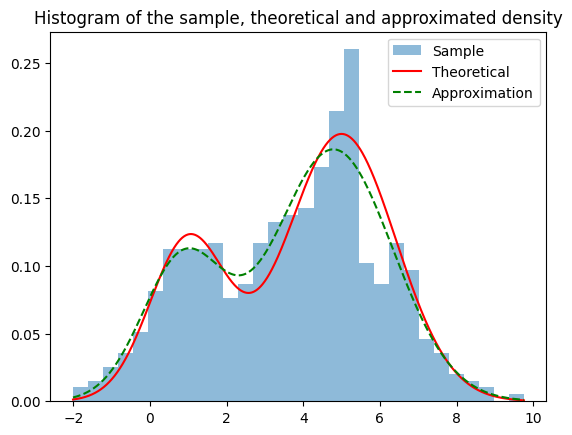

In [110]:
Y_approx = np.array([pi1_em*np.exp(-0.5*(x-mu1_em)**2/sigma1_em)/np.sqrt(2*np.pi*sigma1_em)+pi2_em*np.exp(-0.5*(x-mu2_em)**2/sigma2_em)/np.sqrt(2*np.pi*sigma2_em) for x in X_theoretical])

plt.hist(X_sample, bins=30, density=True, alpha=0.5, label='Sample')
plt.plot(X_theoretical, Y_theoretical, color='red', label='Theoretical')
plt.plot(X_theoretical, Y_approx, color='green', label='Approximation', linestyle='--')
plt.title('Histogram of the sample, theoretical and approximated density')
plt.legend()
plt.show()